# Mini-TP Data Warehouse — Du RAW au schéma en étoile

Ce notebook reprend les étapes du mini-TP : génération des données RAW, staging, création des dimensions, table de faits, agrégations et visualisation.

Fichiers de sortie : `raw_*.csv`, `dim_*.csv`, `fact_sales.csv`, `sales_by_month.csv`, `top_10_products.csv`, `monthly_sales.png`.

Dossier de travail : `/mnt/data/dw_example`

In [2]:
!pip install pandas numpy matplotlib

     --------------------------------------- 11.3/11.3 MB 54.7 MB/s eta 0:00:00
     ------------------------------------- 509.2/509.2 kB 31.2 MB/s eta 0:00:00
     ------------------------------------- 347.8/347.8 kB 22.5 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Imports et configuration
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
out_dir = Path('dw_example')
out_dir.mkdir(exist_ok=True)

## 1) Génération des données RAW

- `raw_customers.csv` : clients
- `raw_products.csv` : produits
- `raw_orders.csv` : lignes de commande

In [4]:
countries = ['FR','DE','ES','IT','UK','US']
raw_customers = pd.DataFrame({
    'customer_id': range(1,121),
    'name': [f'Cust {i}' for i in range(1,121)],
    'email': [f'user{i}@example.com' for i in range(1,121)],
    'country': rng.choice(countries, 120)
})

categories = ['Electronics','Home','Sports','Toys']
brands = ['Acme','Globex','Umbrella','Initech','Soylent']
raw_products = pd.DataFrame({
    'product_id': range(1,61),
    'product_name': [f'Item {i}' for i in range(1,61)],
    'category': rng.choice(categories, 60),
    'brand': rng.choice(brands, 60),
    'unit_price': np.round(rng.uniform(10,300,60),2)
})
raw_products['unit_cost'] = np.round(raw_products['unit_price'] * rng.uniform(0.6,0.8,60),2)

start, end = datetime(2025,1,1), datetime(2025,9,30)
N = 2500
raw_orders = pd.DataFrame({
    'order_id': 10000 + rng.integers(0,10000, N),
    'order_line_id': range(1, N+1),
    'order_ts': [start + timedelta(days=int(x)) for x in rng.integers(0,(end-start).days+1, N)],
    'customer_id': rng.integers(1,121, N),
    'product_id': rng.integers(1,61, N),
    'quantity': rng.integers(1,6, N)
})

raw_customers.to_csv(out_dir/'raw_customers.csv', index=False)
raw_products.to_csv(out_dir/'raw_products.csv', index=False)
raw_orders.to_csv(out_dir/'raw_orders.csv', index=False)

raw_customers.head()

,customer_id,name,email,country
0,1,Cust 1,user1@example.com,FR
1,2,Cust 2,user2@example.com,UK
2,3,Cust 3,user3@example.com,IT
3,4,Cust 4,user4@example.com,ES
4,5,Cust 5,user5@example.com,ES


## 2) Staging : nettoyage et standardisation

In [5]:
stg_customers = raw_customers.assign(
    email = raw_customers['email'].str.strip().str.lower(),
    country = raw_customers['country'].str.upper()
)

stg_products = raw_products.assign(
    category = raw_products['category'].str.title(),
    brand = raw_products['brand'].str.title()
)

stg_orders = raw_orders.copy()
stg_orders['order_ts'] = pd.to_datetime(stg_orders['order_ts'])

stg_customers.head()

,customer_id,name,email,country
0,1,Cust 1,user1@example.com,FR
1,2,Cust 2,user2@example.com,UK
2,3,Cust 3,user3@example.com,IT
3,4,Cust 4,user4@example.com,ES
4,5,Cust 5,user5@example.com,ES


## 3) Dimensions : dim_date, dim_product, dim_customer

In [6]:
dim_date = (pd.DataFrame({'date': pd.to_datetime(stg_orders['order_ts'].dt.normalize().unique())})
            .sort_values('date').reset_index(drop=True))

dim_date['date_sk'] = range(1, len(dim_date)+1)

dim_date = dim_date.assign(
    day = dim_date['date'].dt.day,
    month = dim_date['date'].dt.month,
    quarter = dim_date['date'].dt.quarter,
    year = dim_date['date'].dt.year
)

dim_product = stg_products.drop_duplicates('product_id').reset_index(drop=True)
dim_product['product_sk'] = range(1, len(dim_product)+1)

dim_customer = stg_customers.drop_duplicates('customer_id').reset_index(drop=True)
dim_customer['customer_sk'] = range(1, len(dim_customer)+1)

# Save

dim_date.to_csv(out_dir/'dim_date.csv', index=False)
dim_product[['product_sk','product_id','product_name','category','brand','unit_price','unit_cost']].to_csv(out_dir/'dim_product.csv', index=False)
dim_customer[['customer_sk','customer_id','name','email','country']].to_csv(out_dir/'dim_customer.csv', index=False)

dim_date.head()

,date,date_sk,day,month,quarter,year
0,2025-01-01,1,1,1,1,2025
1,2025-01-02,2,2,1,1,2025
2,2025-01-03,3,3,1,1,2025
3,2025-01-04,4,4,1,1,2025
4,2025-01-05,5,5,1,1,2025


## 4) Table de faits : fact_sales

In [7]:
fact = (stg_orders
        .merge(dim_customer[['customer_id','customer_sk']], on='customer_id')
        .merge(dim_product[['product_id','product_sk','unit_price','unit_cost']], on='product_id')
        .merge(dim_date[['date','date_sk']], left_on=stg_orders['order_ts'].dt.normalize(), right_on=dim_date['date'])
       )

fact['amount'] = fact['quantity'] * fact['unit_price']
fact['cost'] = fact['quantity'] * fact['unit_cost']
fact['margin'] = fact['amount'] - fact['cost']

fact_sales = fact[['order_id','order_line_id','date_sk','product_sk','customer_sk',
                   'quantity','unit_price','amount','cost','margin']].sort_values(['order_id','order_line_id'])

fact_sales.to_csv(out_dir/'fact_sales.csv', index=False)

fact_sales.head()

,order_id,order_line_id,date_sk,product_sk,customer_sk,quantity,unit_price,amount,cost,margin
1835,10005,1836,82,8,51,1,51.91,51.91,32.13,19.78
1961,10010,1962,122,38,77,3,201.23,603.69,377.16,226.53
1007,10012,1008,20,7,36,5,105.66,528.30,356.45,171.85
1778,10012,1779,124,54,18,1,281.45,281.45,202.42,79.03
928,10015,929,54,20,64,4,33.99,135.96,90.00,45.96


## 5) Agrégations et analyses
- Ventes mensuelles
- Top 10 produits par chiffre d'affaires

In [8]:
sales_by_month = (fact_sales.merge(dim_date[['date_sk','month','year']], on='date_sk')
                  .groupby(['year','month'], as_index=False)['amount'].sum()
                  .sort_values(['year','month']))

top_products = (fact_sales.merge(dim_product[['product_sk','product_name']], on='product_sk')
                .groupby(['product_sk','product_name'], as_index=False)['amount'].sum()
                .sort_values('amount', ascending=False).head(10))

sales_by_month.to_csv(out_dir/'sales_by_month.csv', index=False)
top_products.to_csv(out_dir/'top_10_products.csv', index=False)

sales_by_month.head()

,year,month,amount
0,2025,1,124990.29
1,2025,2,101977.92
2,2025,3,126423.63
3,2025,4,131557.13
4,2025,5,130404.35


## 6) Visualisation : chiffre d'affaires mensuel

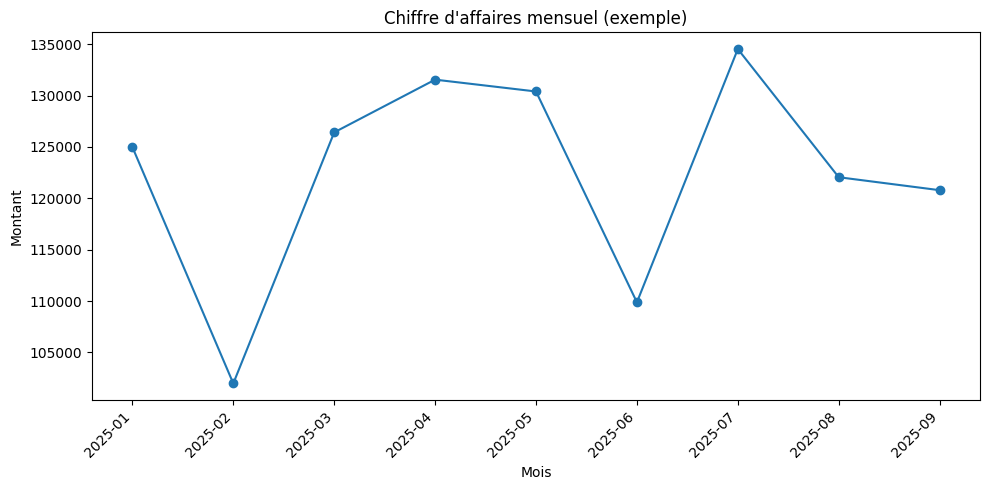

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
x = range(len(sales_by_month))
labels = [f"{int(y)}-{int(m):02d}" for y,m in zip(sales_by_month['year'], sales_by_month['month'])]
plt.plot(x, sales_by_month['amount'], marker='o')
plt.title('Chiffre d\'affaires mensuel (exemple)')
plt.xlabel('Mois')
plt.ylabel('Montant')
plt.xticks(x[::max(1, len(x)//10)], [labels[i] for i in range(0, len(labels), max(1, len(x)//10))], rotation=45, ha='right')
plt.tight_layout()
plt.savefig(out_dir/'monthly_sales.png', dpi=150)
plt.show()

## Fichiers produits
- raw_customers.csv
- raw_products.csv
- raw_orders.csv
- dim_date.csv
- dim_product.csv
- dim_customer.csv
- fact_sales.csv
- sales_by_month.csv
- top_10_products.csv
- monthly_sales.png

Les fichiers sont enregistrés dans `/mnt/data/dw_example`

In [10]:
# raw_promotions.csv : promotions produits
raw_promotions = pd.DataFrame({
    'promotion_id': range(1, 21),
    'promotion_name': [f'Promo {i}' for i in range(1, 21)],
    'discount_pct': np.round(rng.uniform(5, 30, 20), 2)
})
raw_inventory = pd.DataFrame({
    'product_id': rng.integers(1, 61, 1000),
    'inventory_date': [start + timedelta(days=int(x)) for x in rng.integers(0, (end-start).days+1, 1000)],
    'stock_qty': rng.integers(0, 100, 1000)
})
raw_promotions.to_csv(out_dir/'raw_promotions.csv', index=False)
raw_inventory.to_csv(out_dir/'raw_inventory.csv', index=False)


In [11]:
#nettoyage des nouvelles données
stg_promotions = raw_promotions.assign(
    promotion_name=raw_promotions['promotion_name'].str.strip().str.title()
)
stg_inventory = raw_inventory.copy()
stg_inventory['inventory_date'] = pd.to_datetime(stg_inventory['inventory_date'])


In [12]:
# Dimension Promotion
dim_promotion = stg_promotions.drop_duplicates('promotion_id').reset_index(drop=True)
dim_promotion['promotion_sk'] = range(1, len(dim_promotion)+1)
dim_promotion.to_csv(out_dir/'dim_promotion.csv', index=False)

In [13]:
# SCD2 sur dim_customer
dim_customer_scd2 = dim_customer.copy()
dim_customer_scd2['valid_from'] = pd.Timestamp('2025-01-01')
dim_customer_scd2['valid_to'] = pd.NaT
dim_customer_scd2['is_current'] = True
dim_customer_scd2.to_csv(out_dir/'dim_customer_scd2.csv', index=False)

In [14]:
# Ajout de promotion_id aléatoire dans les commandes
fact_sales['promotion_id'] = rng.choice(dim_promotion['promotion_id'], len(fact_sales))
fact_sales = fact_sales.merge(dim_promotion[['promotion_id', 'promotion_sk']], on='promotion_id', how='left')

# Table de faits : inventaire
fact_inventory = stg_inventory.merge(dim_product[['product_id', 'product_sk']], on='product_id')
fact_inventory = fact_inventory.merge(dim_date[['date', 'date_sk']], left_on='inventory_date', right_on='date')
fact_inventory = fact_inventory[['date_sk', 'product_sk', 'stock_qty']]
fact_inventory.to_csv(out_dir/'fact_inventory.csv', index=False)


In [15]:
#Vue matérialisée des ventes hebdomadaires
fact_sales = fact_sales.merge(dim_date[['date_sk', 'date']], on='date_sk')
fact_sales['week'] = fact_sales['date'].dt.isocalendar().week
fact_sales['year'] = fact_sales['date'].dt.year
weekly_sales = (fact_sales.groupby(['year', 'week'], as_index=False)['amount'].sum()
                .sort_values(['year', 'week']))
weekly_sales.to_csv(out_dir/'weekly_sales_view.csv', index=False)

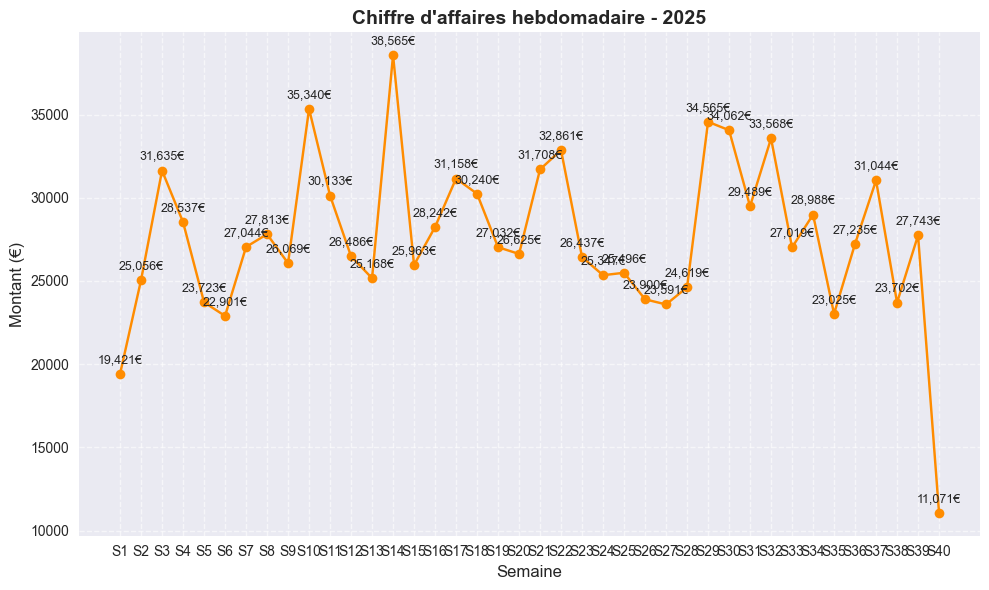

In [17]:
# Création du graphique linéaire
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 6))
x = weekly_sales['week']
y = weekly_sales['amount']

ax.plot(x, y, marker='o', linestyle='-', color='darkorange')

# Titres et axes
ax.set_title("Chiffre d'affaires hebdomadaire - 2025", fontsize=14, weight='bold')
ax.set_xlabel("Semaine", fontsize=12)
ax.set_ylabel("Montant (€)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([f"S{w}" for w in x])
ax.grid(True, linestyle='--', alpha=0.6)
# Annotations des points
for i, val in enumerate(y):
    ax.annotate(f'{val:,.0f}€', (x[i], y[i]), textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=9)

# Mise en page et sauvegarde
plt.tight_layout()
plt.savefig("weekly_sales_line.png", dpi=150)
plt.show()

In [18]:
# Emails valides
dq_email_valid = stg_customers['email'].str.contains(r'^[\w\.-]+@[\w\.-]+\.\w+$', regex=True)

# Valeurs non nulles
dq_not_null = stg_customers.notnull().all(axis=1)

# Rapport
dq_report = pd.DataFrame({
    'customer_id': stg_customers['customer_id'],
    'email_valid': dq_email_valid,
    'not_null': dq_not_null,
    'dq_pass': dq_email_valid & dq_not_null
})
dq_report.to_csv(out_dir/'dq_report.csv', index=False)
